In [12]:
from typing import Dict
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from plot import plot_hbar_groups

In [25]:
vulns_df = pd.read_csv(os.path.join("data", "out", "vulns.csv"))
comps_df = pd.read_csv(os.path.join("data", "out", "components.csv"))
meta_df = pd.read_csv(os.path.join("data", "out", "metadata.csv"))

JOIN_COL = ["registry_domain", "registry_path", "image_name", "image_tag"]

In [21]:
def format_df(df: pd.DataFrame, column: str) -> Dict:
    types = df["report_type"].unique()
    ids = df["compare_id"].unique()
    members = {t: [] for t in types}

    for t in members.keys():
        for id in ids:
            tmask = df["report_type"] == t
            imask = df["compare_id"] == id
            filtered = df[tmask & imask][column]
            if filtered.shape[0] == 0:
                val = 0
            else:
                val = filtered.iloc[0]
            members[t].append(val)
    
    return members, ids

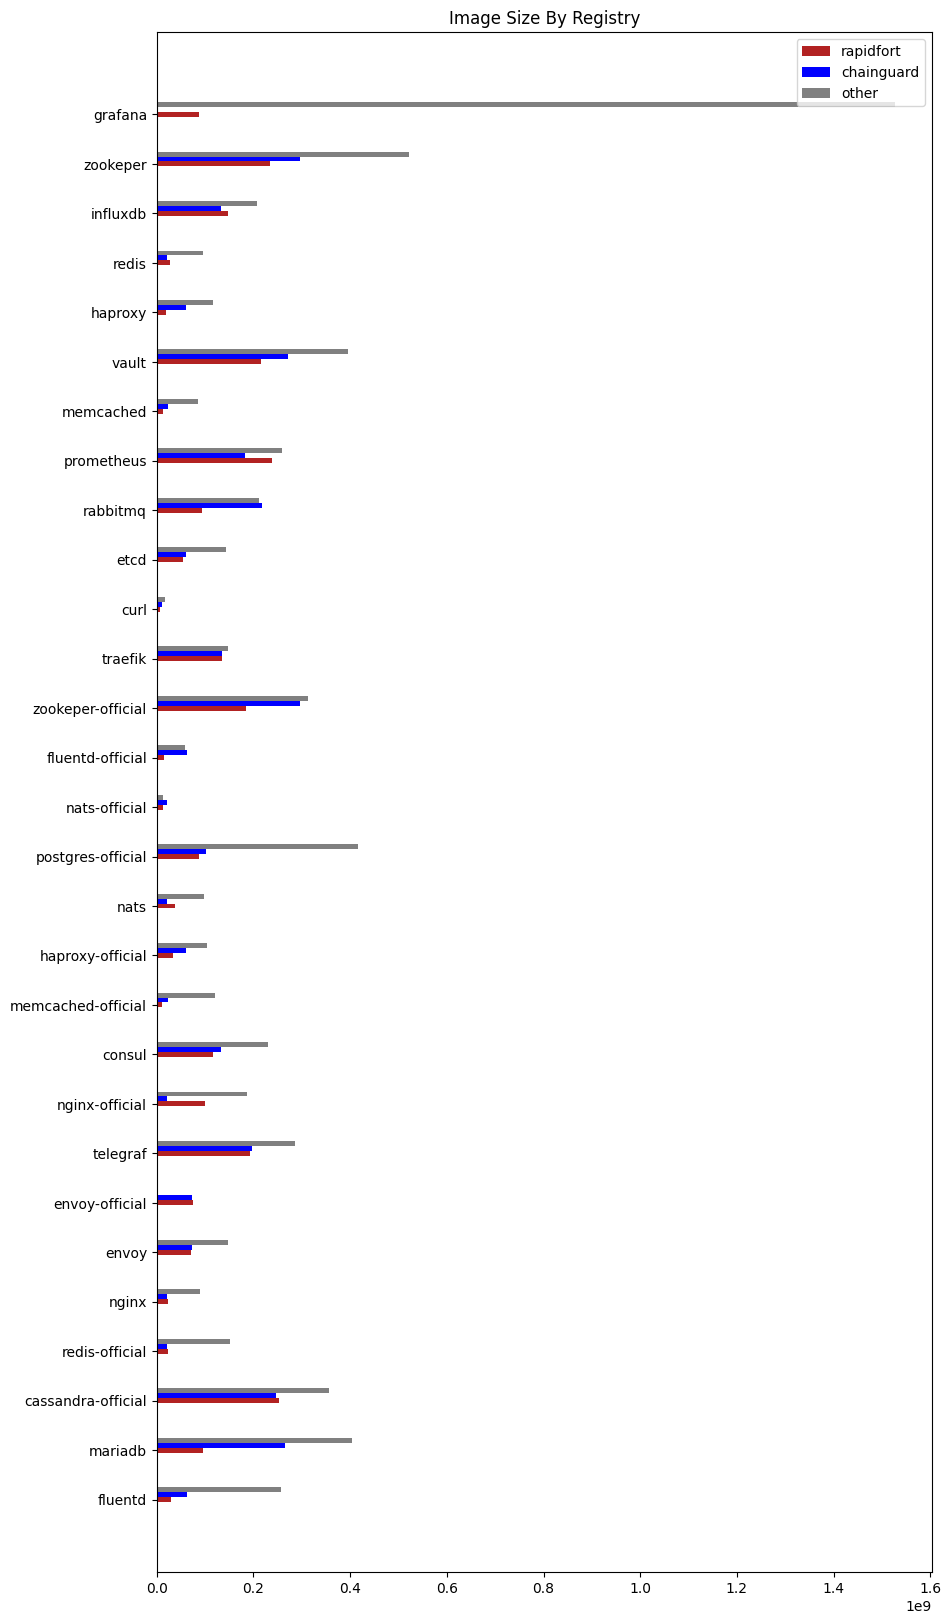

In [63]:
# Image size by registry

img_sz_df = meta_df.drop(["registry_domain",
                          "registry_path",
                          "image_name",
                          "image_tag"], axis=1)

members, groups = format_df(img_sz_df, "image_size")
colors = {
            "chainguard": "blue",
            "rapidfort": "firebrick",
            "other": "gray"
}
fig, ax = plt.subplots(figsize=(10,20))
ax.set_title("Image Size By Registry")

plot_hbar_groups(ax, members, groups, colors)

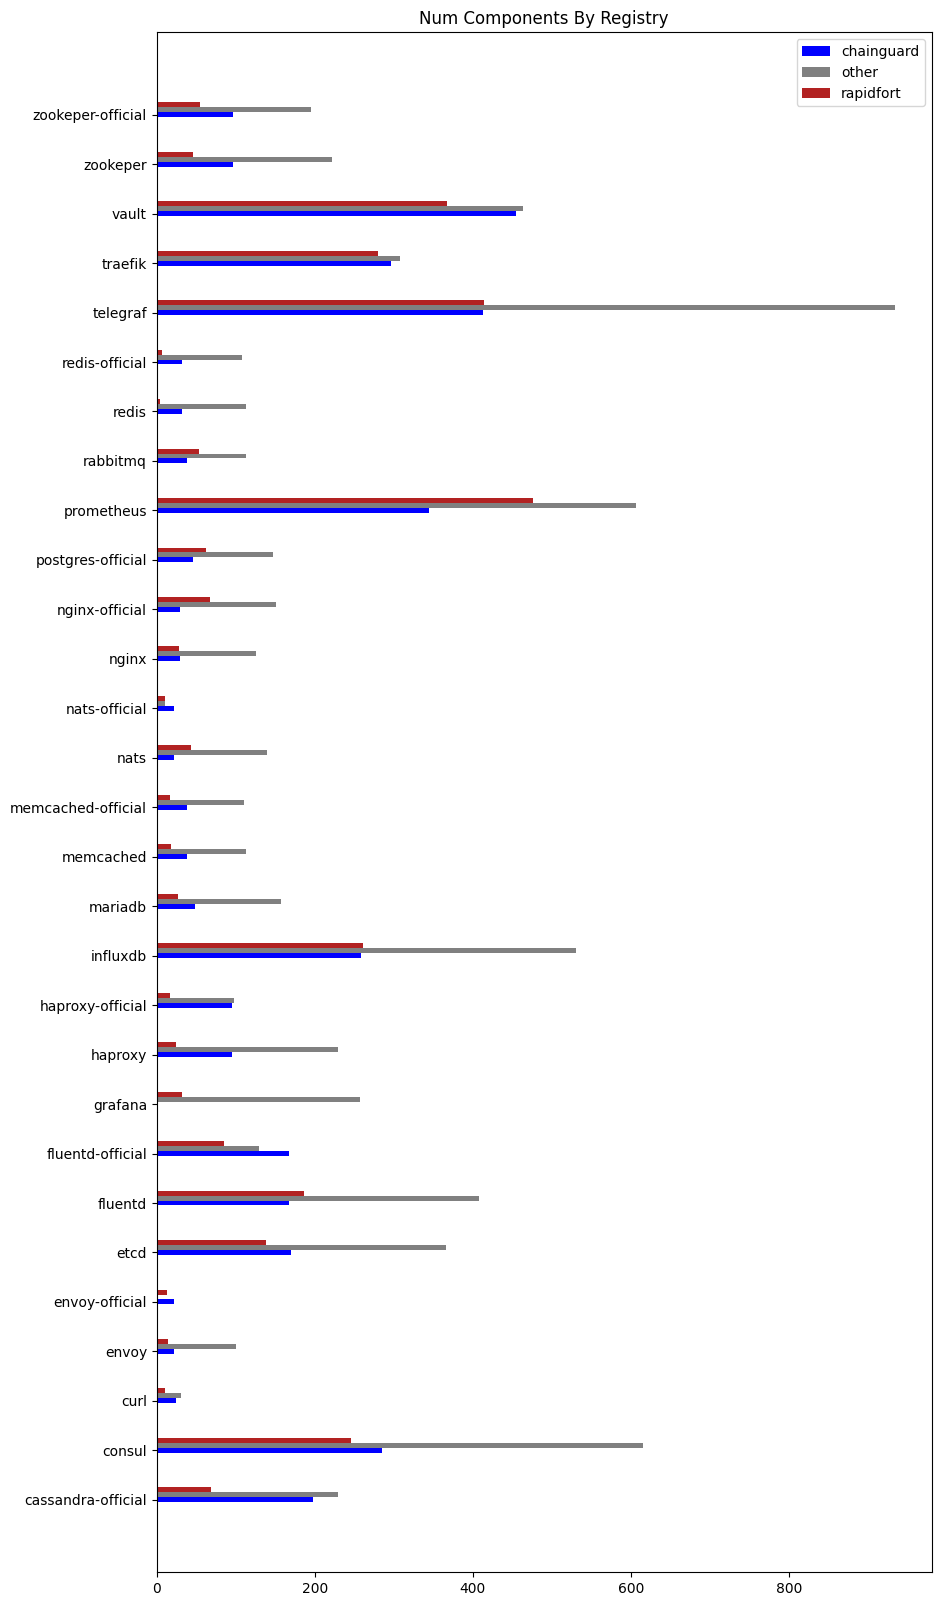

In [64]:
# Number of components by registry

n_comps_df = comps_df.drop(["registry_domain",
                          "registry_path",
                          "image_name",
                          "image_tag",
                          "type"], axis=1) \
                    .groupby(["compare_id", "report_type"]) \
                    .count() \
                    .reset_index() \
                    .rename(columns={"component_name": "n_components"})

members, groups = format_df(n_comps_df, "n_components")
colors = {
            "chainguard": "blue",
            "rapidfort": "firebrick",
            "other": "gray"
}

fig, ax = plt.subplots(figsize=(10,20))
ax.set_title("Num Components By Registry")

plot_hbar_groups(ax, members, groups, colors)

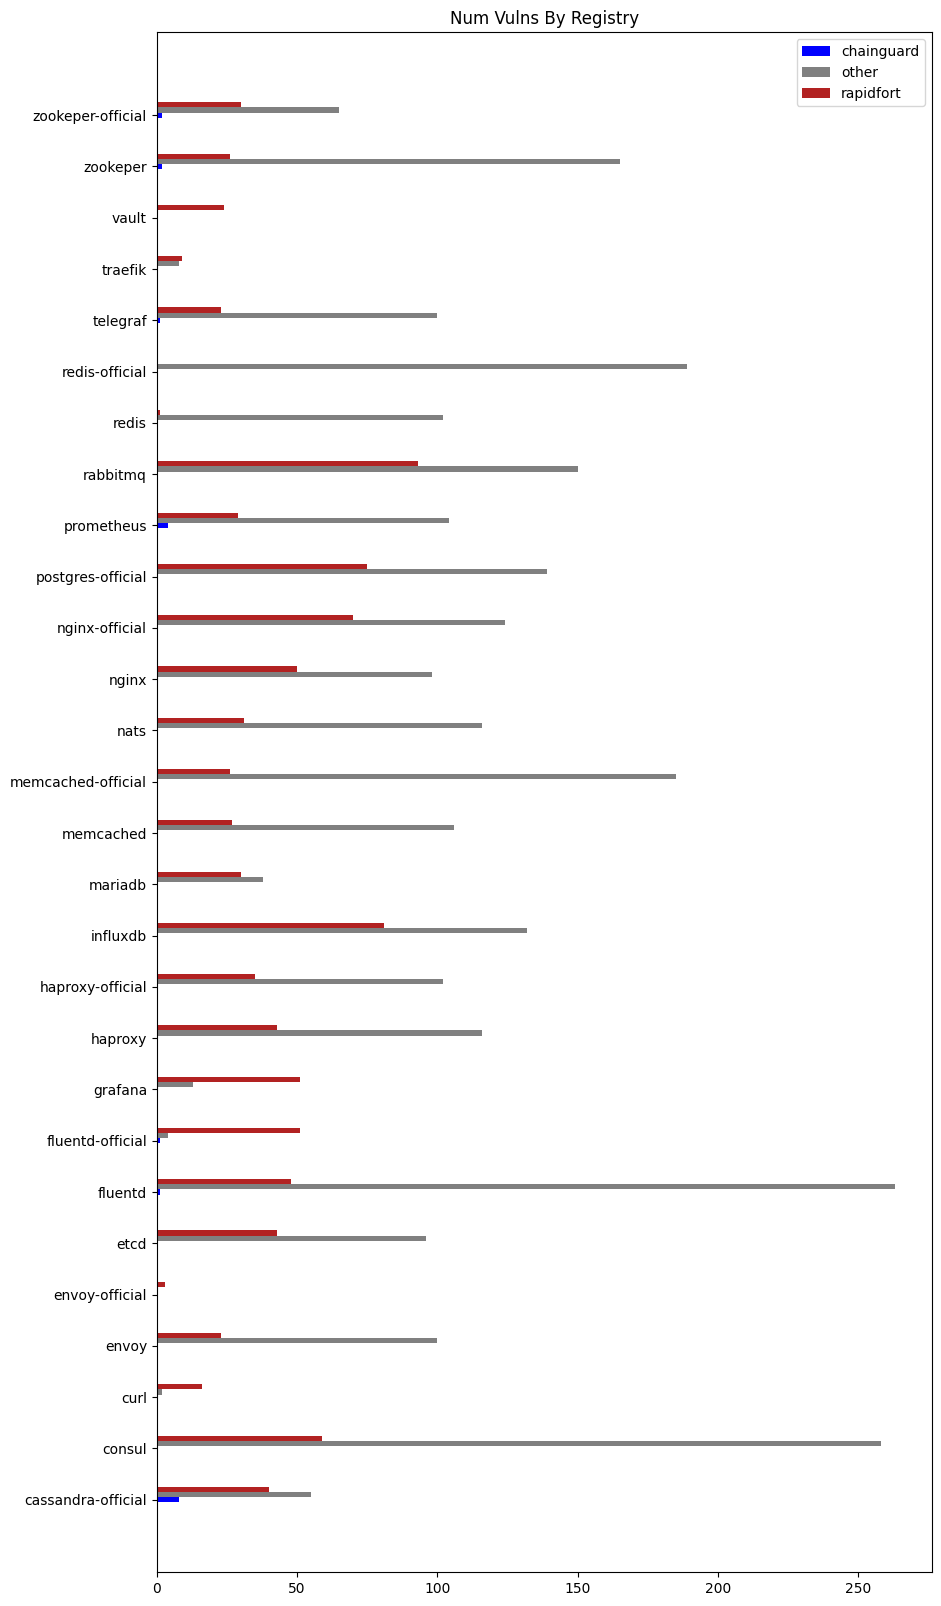

In [65]:
# Number of vulns by registry

n_vulns_df = vulns_df.drop(["registry_domain",
                          "registry_path",
                          "image_name",
                          "image_tag",
                          "type"], axis=1) \
                    .groupby(["compare_id", "report_type"]) \
                    .count() \
                    .reset_index() \
                    .rename(columns={"severity": "n_vulns"})

members, groups = format_df(n_vulns_df, "n_vulns")
colors = {
            "chainguard": "blue",
            "rapidfort": "firebrick",
            "other": "gray"
}

fig, ax = plt.subplots(figsize=(10,20))
ax.set_title("Num Vulns By Registry")

plot_hbar_groups(ax, members, groups, colors)

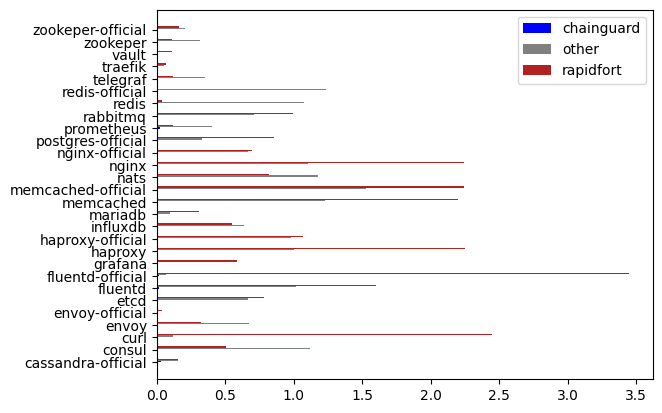

In [56]:
# TODO
# Vulns per MB by registry

bytes_p_mb = 1000000

vulns_p_mb_df = n_vulns_df.merge(img_sz_df, how="left",
                                  on=["compare_id", "report_type"])

vulns_p_mb_df["v_p_mb"] = \
    vulns_p_mb_df["n_vulns"] / (vulns_p_mb_df["image_size"] / bytes_p_mb)

members, groups = format_df(vulns_p_mb_df, "v_p_mb")
colors = {
            "chainguard": "blue",
            "rapidfort": "firebrick",
            "other": "gray"
}

fig, ax = plt.subplots(figsize=(10,20))
ax.set_title("Vulns per MB By Registry")

plot_hbar_groups(ax, members, groups, colors)

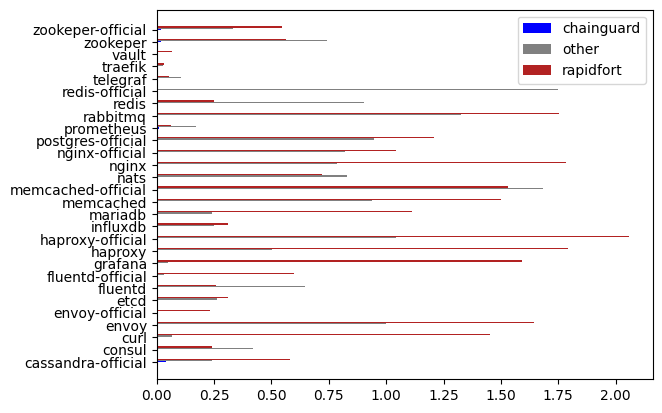

In [57]:
# TODO
# Vulns per component by registry

vulns_p_comp_df = n_vulns_df.merge(n_comps_df, how="left",
                                   on=["compare_id", "report_type"])

vulns_p_comp_df["v_p_comp"] = \
    vulns_p_comp_df["n_vulns"] / vulns_p_comp_df["n_components"]

members, groups = format_df(vulns_p_comp_df, "v_p_comp")
colors = {
            "chainguard": "blue",
            "rapidfort": "firebrick",
            "other": "gray"
}
fig, ax = plt.subplots()

plot_hbar_groups(ax, members, groups, colors)